In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from sionna.rt import load_scene, Transmitter, Receiver, Camera, RadioMapSolver, PathSolver
import matplotlib.pyplot as plt

In [2]:
mi.set_variant("llvm_ad_mono_polarized")

In [3]:
import sionna.rt as rt

In [4]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago\DowntownChicago1KM.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)

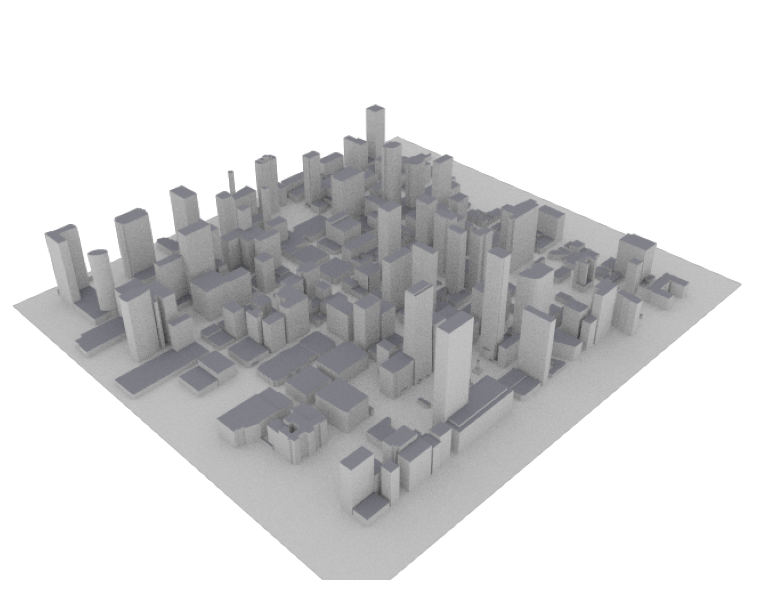

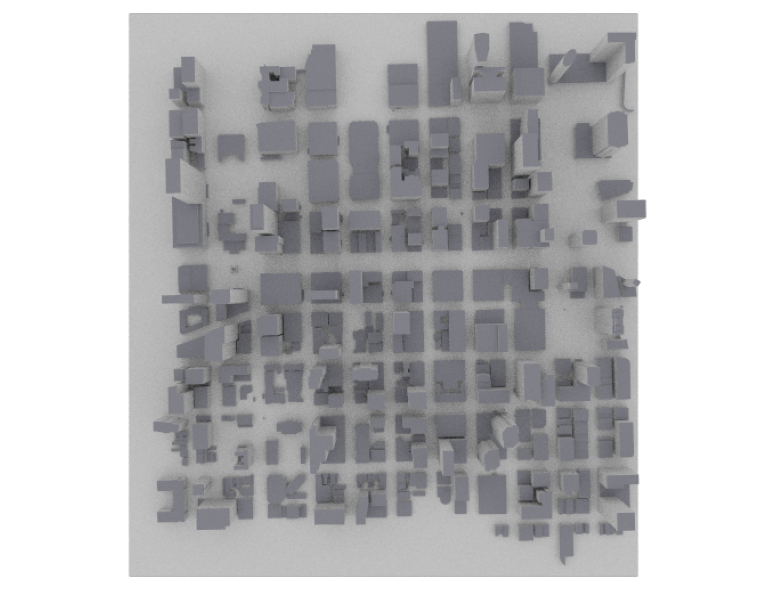

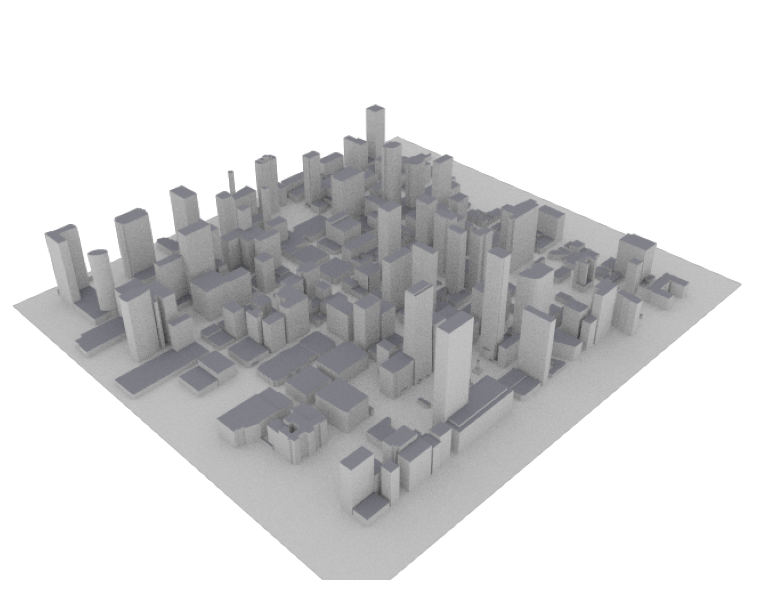

In [5]:
overhead = Camera(position=(0.0, 0.0, 2000.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

isometric = Camera(position=(1200.0, 1200.0, 1200.0))
isometric.look_at((0.0,0.0,0.0))
scene.render(camera=isometric)

# Camera on render should be Z up, Y forwards!

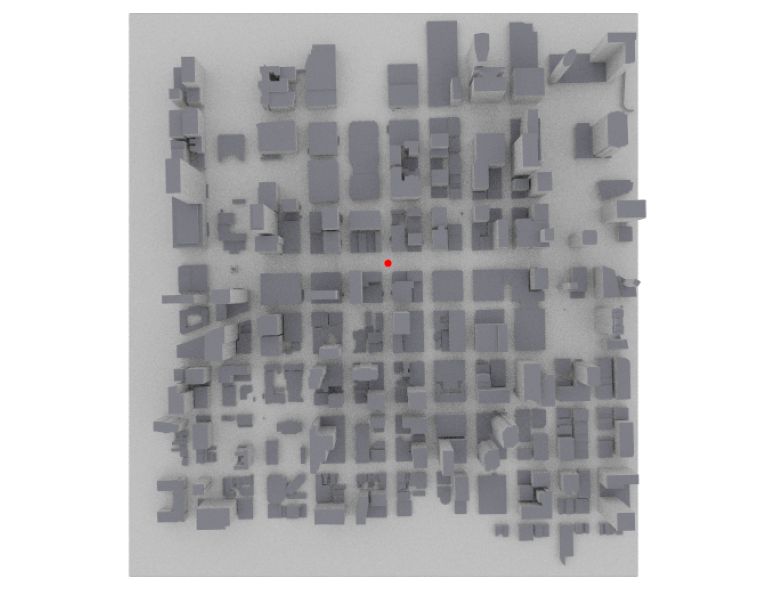

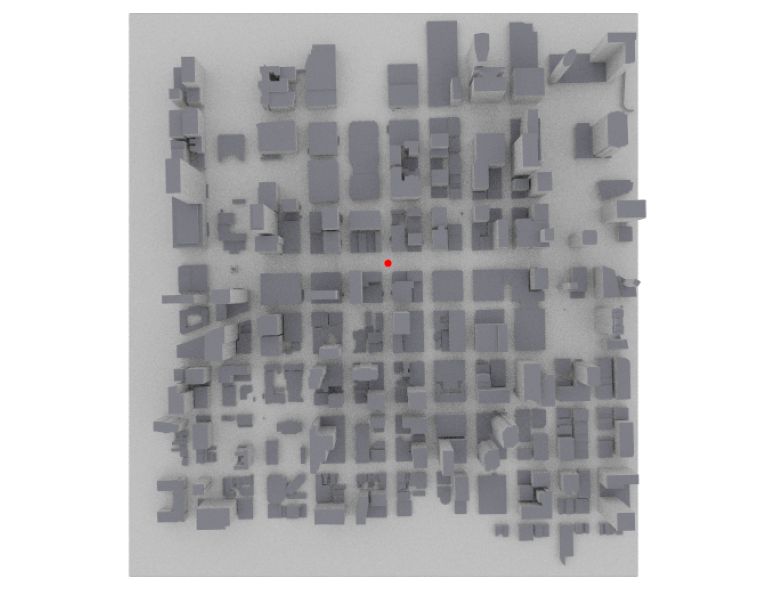

In [6]:
# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter
tx = Transmitter(name="Tx1", position=[70,-10,10], color=[1.0, 0.0, 0.0])
scene.add(tx)
# Visualize scene with transmitter and receivers in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

[[[-43.88212  -47.220066 -39.19248  ... -27.527279 -36.89488  -30.332773]
  [-38.824554 -36.872284 -38.526985 ... -32.70408  -36.558617 -46.69965 ]
  [-37.746056 -44.30783  -36.084797 ... -32.083664 -36.534008 -38.118942]
  ...
  [-52.004677 -40.193497 -38.873962 ... -51.09356  -46.365997 -40.691586]
  [      -inf -40.29384  -40.677895 ...       -inf -51.983875       -inf]
  [-60.690002 -49.757088 -49.130177 ... -40.603573       -inf       -inf]]]


C:\Users\sawyer\AppData\Local\Temp\ipykernel_26628\4087209504.py:43: RuntimeWarning: divide by zero encountered in log
  print(f"{np.log(rss)}")


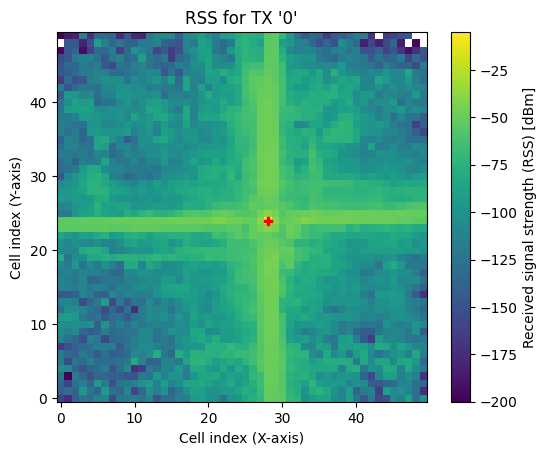

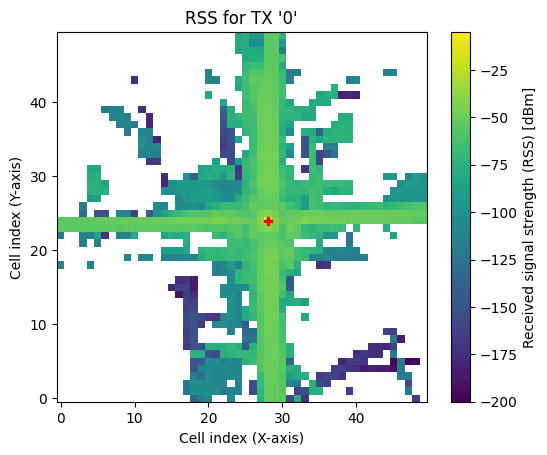

In [17]:

x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10
cell_size = (20, 20)

map_width = x_max - x_min
map_height = y_max - y_min
map_center = [(x_min + x_max) / 2, (y_min + y_max) / 2, z_height]

rm_solver = RadioMapSolver()

rm = rm_solver(
    scene,
    max_depth=25,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)


rm_3 = rm_solver(
    scene,
    max_depth=3,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

rm.show(metric="rss", tx=0, show_tx=True, vmin=-200)
rm_3.show(metric="rss", tx=0, show_tx=True, vmin=-200)

rss = np.array(rm.rss)
print(f"{np.log(rss)}")


CIR shape: (2, 20, 1, 1, 1, 46, 1)
Number of receivers: 20
Rx_0 at position [ 120.373055 -468.29617    10.      ]: 3 paths, total power: -121.54 dB
Rx_1 at position [-40.83276 395.80374  10.     ]: 0 paths, total power: -inf dB
Rx_2 at position [ 35.63388 173.4164   10.     ]: 28 paths, total power: -101.01 dB
Rx_3 at position [ 57.08917 256.7864   10.     ]: 20 paths, total power: -89.87 dB
Rx_4 at position [71.422134 27.146446 10.      ]: 46 paths, total power: -74.45 dB
Rx_5 at position [-45.068455 130.66919   10.      ]: 0 paths, total power: -inf dB
Rx_6 at position [-411.37897    -5.261636   10.      ]: 7 paths, total power: -105.80 dB
Rx_7 at position [473.69086   71.942955  10.      ]: 7 paths, total power: -125.53 dB
Rx_8 at position [154.76202 104.74343  10.     ]: 6 paths, total power: -128.88 dB
Rx_9 at position [ 120.8145  -421.03592   10.     ]: 10 paths, total power: -120.40 dB
Rx_10 at position [207.35594  -46.647556  10.      ]: 16 paths, total power: -116.01 dB
Rx_11 

C:\Users\sawyer\AppData\Local\Temp\ipykernel_26628\2840911718.py:41: RuntimeWarning: divide by zero encountered in log10
  print(f"Rx_{i} at position {positions[i]}: {num_paths} paths, total power: {10*np.log10(total_power):.2f} dB")


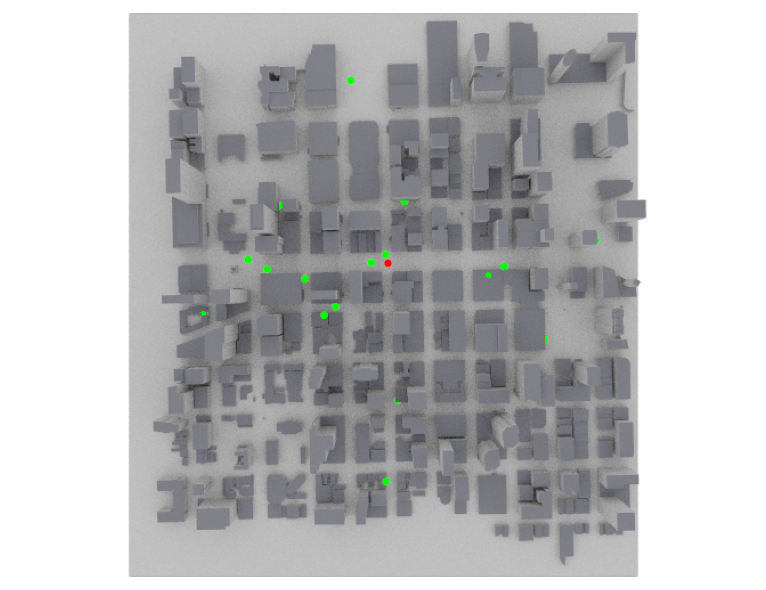

In [ ]:
# Sample specific positions from the RadioMap for PathSolver analysis
positions, cell_indices = rm.sample_positions(
    num_pos=20,
    metric='rss',
    min_val_db=-80,
    max_dist=500
)

# Convert to numpy and add receivers at those positions
positions = positions.numpy()
positions = np.squeeze(positions, axis=0)  # Shape: [10, 3]

for i, pos in enumerate(positions):
    rx = Receiver(name=f"Rx_{i}", position=pos, color=[0.0, 1.0, 0.0])
    scene.add(rx)

cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

# Now use PathSolver to get detailed path information for these receivers
path_solver = PathSolver()
paths = path_solver(scene, max_depth=5)

# Get channel impulse response
a, tau = paths.cir()

# Convert to numpy array
a = np.array(a)
tau = np.array(tau)

print(f"CIR shape: {a.shape}")
print(f"Number of receivers: {len(positions)}")

# Analyze paths for each receiver
for i in range(len(positions)):
    a_rx = a[0, i, 0, 0, 0, :, 0]  # Get path coefficients for receiver i
    num_paths = np.sum(np.abs(a_rx) > 1e-10)  # Count significant paths
    total_power = np.sum(np.abs(a_rx)**2)
    
    print(f"Rx_{i} at position {positions[i]}: {num_paths} paths, total power: {10*np.log10(total_power):.2f} dB")

scene.preview(paths=paths, clip_at=20)


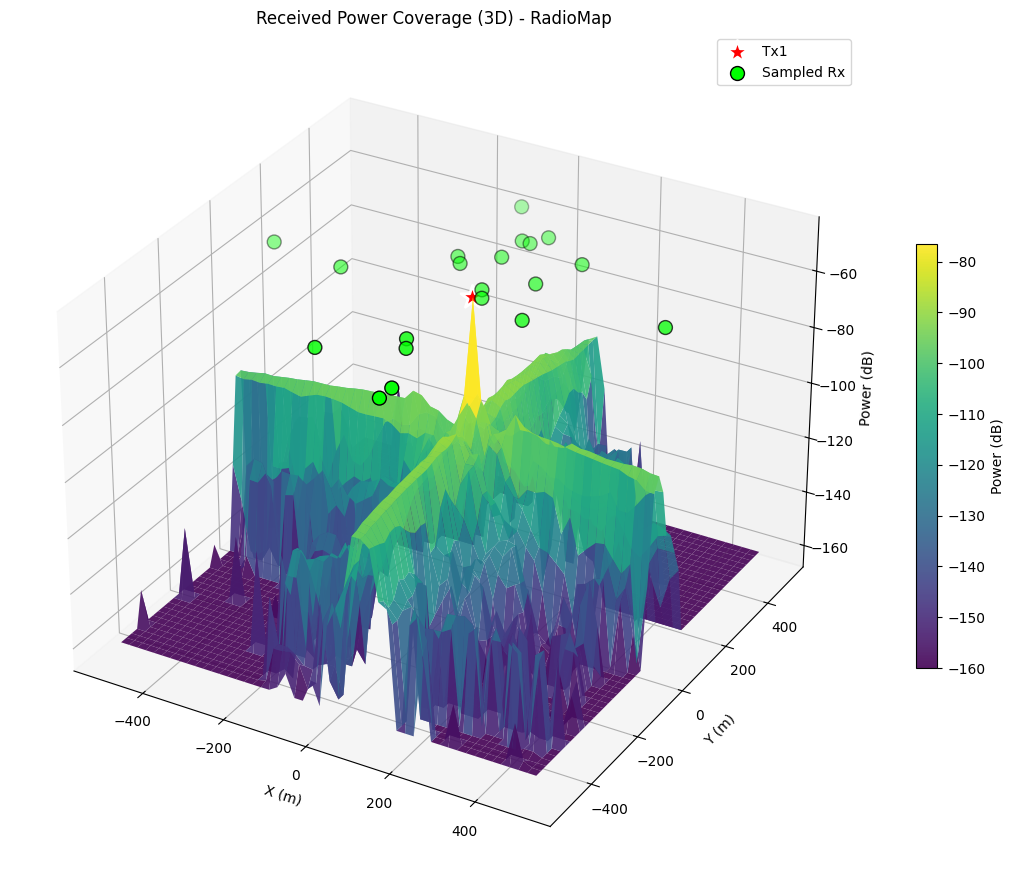


Power range: -160.00 to -49.07 dB


In [9]:
#--------------------------Visualize RadioMap Data in 3D----------------------------#


# Extract RadioMap data
path_gain = np.array(rm.path_gain)  # Shape: [num_tx, cells_y, cells_x]
rss_data = path_gain[0, :, :]  # Get first transmitter

# Convert to dB
power_grid_db = 10 * np.log10(rss_data + 1e-16)

# Create coordinate grids
num_cells_y, num_cells_x = power_grid_db.shape
x_coords = np.linspace(x_min, x_max, num_cells_x)
y_coords = np.linspace(y_min, y_max, num_cells_y)
X, Y = np.meshgrid(x_coords, y_coords)

# Create 3D surface plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, power_grid_db, cmap='viridis', 
                       edgecolor='none', alpha=0.9)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Power (dB)')
ax.set_title('Received Power Coverage (3D) - RadioMap')

# Add transmitter location (at position [70, -10, 10])
tx_pos = [70, -10]
ax.scatter([tx_pos[0]], [tx_pos[1]], [power_grid_db.max()], 
           color='red', s=300, marker='*', label='Tx1', 
           edgecolors='white', linewidths=2)

# Add sampled receiver positions
if len(positions) > 0:
    ax.scatter(positions[:, 0], positions[:, 1], 
               [power_grid_db.max()] * len(positions),
               color='lime', s=100, marker='o', label='Sampled Rx',
               edgecolors='black', linewidths=1)

fig.colorbar(surf, ax=ax, shrink=0.5, label='Power (dB)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nPower range: {power_grid_db.min():.2f} to {power_grid_db.max():.2f} dB")



In [15]:
scene.preview(radio_map=rm, rm_vmin=-160)